# Lecture 2 exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import mne
import os
from mne.datasets import sample
from scipy.fft import rfft, rfftfreq

In [2]:
%matplotlib inline

### 1. Loading multivariate time-domain data

In [3]:
meg_data = np.load('sample_audvis_raw.npy')
evt = np.load('events.npy')
print(meg_data.shape)
print(evt.shape)

(305, 166800)
(320,)


number of time-samples: 166800; number of channels: 305; number of events: 320

### 2. Filtering raw data

#### 2(a) Implementing filters on raw data 

In [4]:
fs = 600 # sample freq
time = np.arange(meg_data.shape[1]) / fs

In [5]:
def plotSignal(signal, title, time):
    # fig = plt.figure(figsize=(8, 6))
    plt.plot(time, signal)
    plt.title(title)

In [6]:
# Function for computing and plotting the power spectrum of time domain signals:
def plotFrequnecySpectrum(signal, fs, title):
    fig = plt.figure(figsize=(8, 6))
    yf = rfft(signal)
    xf = rfftfreq(signal.size, 1 / fs)
    
    plt.xlabel('Frequency [Hz]', fontsize=20)
    plt.ylabel('Amplitude [dB]', fontsize=20)
    plt.title(title)
    plt.plot(xf, np.abs(yf))
    plt.show()

In [7]:
# Function for filtering a signal:
def filterSignal(fc, fs, input_signal, lp=None, hp=None, notch=None, order=5, quality_factor=20, pad = 'odd'):
    ## filter simulated data
    # fc Cut-off frequency of the filter
    #if lp == True or hp == True:
    w = fc / (fs / 2) # Normalize the frequency (fs/2 is for nyq) 
    if lp == True:
        b, a = signal.butter(order, w, 'lowpass')
    elif hp == True:
        b, a = signal.butter(order, w, 'highpass')
    elif notch == True: 
        #b, a = signal.butter(order, [w[0], w[1]], btype='bandstop')
        # Design a notch filter using signal.iirnotch
        b, a = signal.iirnotch(fc, quality_factor, fs)
        
        # Compute magnitude response of the designed filter
        freq, h = signal.freqz(b, a, fs=fs)

        fig = plt.figure(figsize=(8, 6))

        # Plot magnitude response of the filter
        plt.plot(freq*fs/(2*np.pi), 20 * np.log10(abs(h)),
                 'r', label='Bandpass filter', linewidth='2')
        plt.xlabel('Frequency [Hz]', fontsize=20)
        plt.ylabel('Amplitude [dB]', fontsize=20)
        plt.title('Notch Filter', fontsize=20)
        plt.grid()

        
    output = signal.filtfilt(b, a, input_signal, padtype = pad)
    
    return output

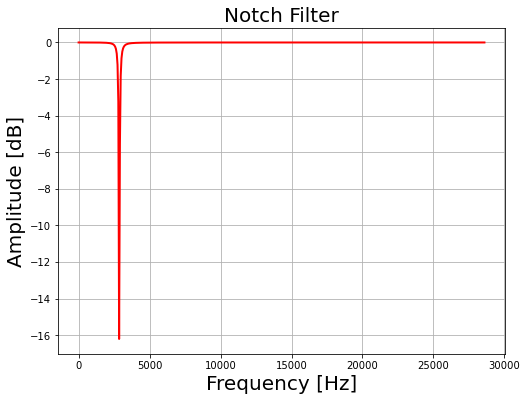

In [8]:
# apply notch filter
meg_notched = filterSignal(30,fs,meg_data[:],notch=True)

In [9]:
# apply high pass filter
meg_highp = filterSignal(1, fs, meg_notched, hp=True)

In [10]:
# apply low pass filter
meg_lowp = filterSignal(20, fs, meg_highp, lp=True)

(0.0, 1.0)

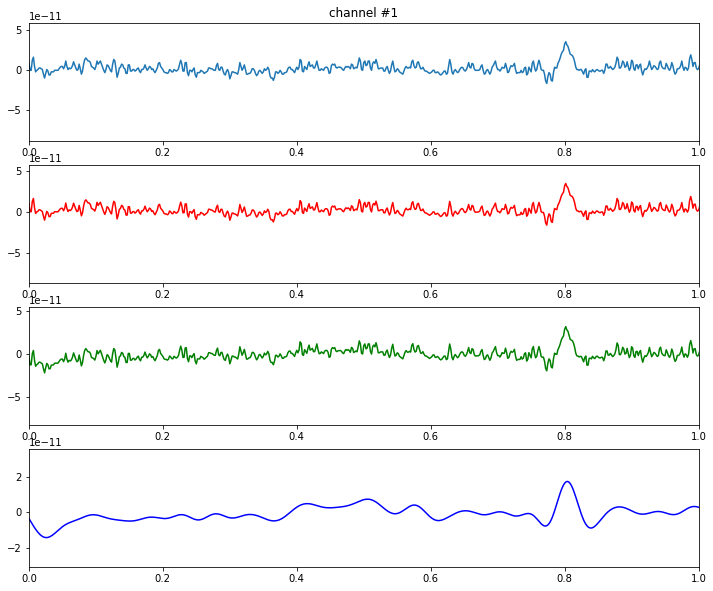

In [11]:
# pick channel 1 as an example
plt.figure(figsize=(12,10))
plt.subplot(411)
plotSignal(meg_data[0], 'channel #1', time)
plt.xlim(0,1)
# plot notch-filtered version of signal
plt.subplot(412)
plt.plot(time, meg_notched[0], color = 'r')
plt.xlim(0,1)
# plot highpass-filtered version of signal
plt.subplot(413)
plt.plot(time, meg_highp[0], color = 'g')
plt.xlim(0,1)
# plot lowpass-filtered version of signal
plt.subplot(414)
plt.plot(time, meg_lowp[0], color = 'b')
plt.xlim(0,1)

<Figure size 576x432 with 0 Axes>

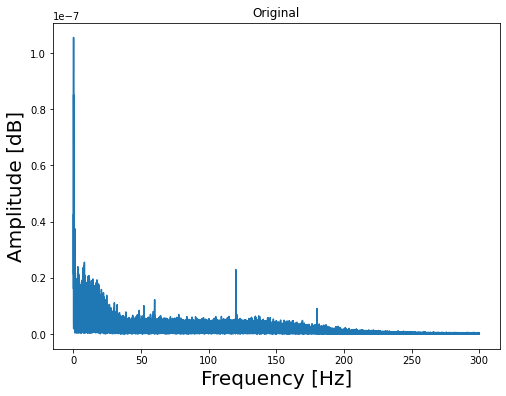

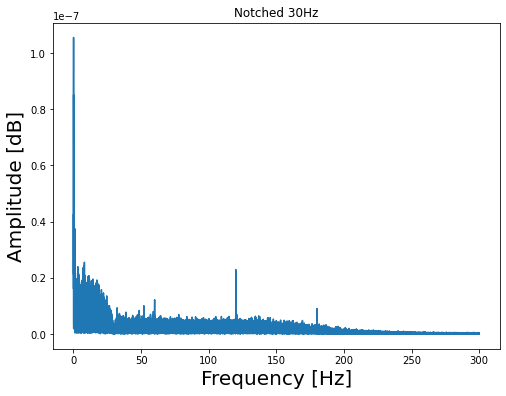

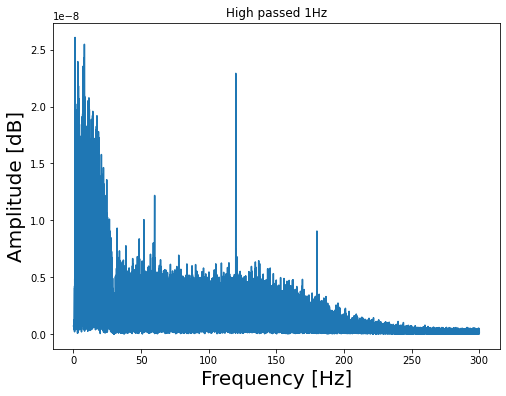

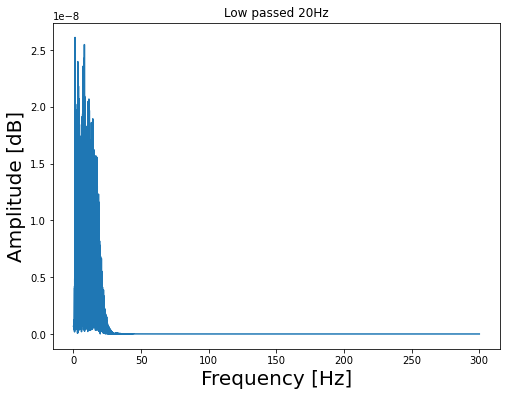

In [12]:
plt.figure(figsize=(8,6))
plotFrequnecySpectrum(meg_data[0], fs, 'Original')
plotFrequnecySpectrum(meg_notched[0], fs, 'Notched 30Hz')
plotFrequnecySpectrum(meg_highp[0], fs, 'High passed 1Hz')
plotFrequnecySpectrum(meg_lowp[0], fs, 'Low passed 20Hz')

#### 2(b) Describing the effects of filtering 

From the power spectrums, after notch filter of cut off frequency of 30Hz, we see that there is a notch around 30Hz. 

After high pass filter of 1Hz only waves of a frequency higher than 1Hz can pass. In the plot the difference is not very big because 0-1Hz is a very small range. [note that Amplitude order changed from 1e-7 to 1e08, so the two plots are similar]

After low pass filter of 20Hz we can clearly see that waves has a frequency less than 20Hz can pass. We can also see from the signal plot, the last subplot of final filtered meg data is more flat. Noises of higher frequency are cut off.

### 3. Epoching the data

#### 3(a) Extracting epochs

In [13]:
base_w = 100
post_w = 500
data_l = np.zeros((len(evt), meg_data.shape[0], (base_w+post_w)))

In [14]:
for ev in np.arange(len(evt)):
    data_l[ev,:] = meg_data[:, evt[ev]-base_w : evt[ev]+post_w]

In [15]:
print(data_l.shape)

(320, 305, 600)


#### 3(b) Plotting average epochs 

In [16]:
avg_epoch = np.mean(data_l, axis = 0)
avg_time = np.arange(data_l.shape[2]) / fs

In [17]:
# The number of channels is 305. I cannot draw all of them, take first 5 as an exp.

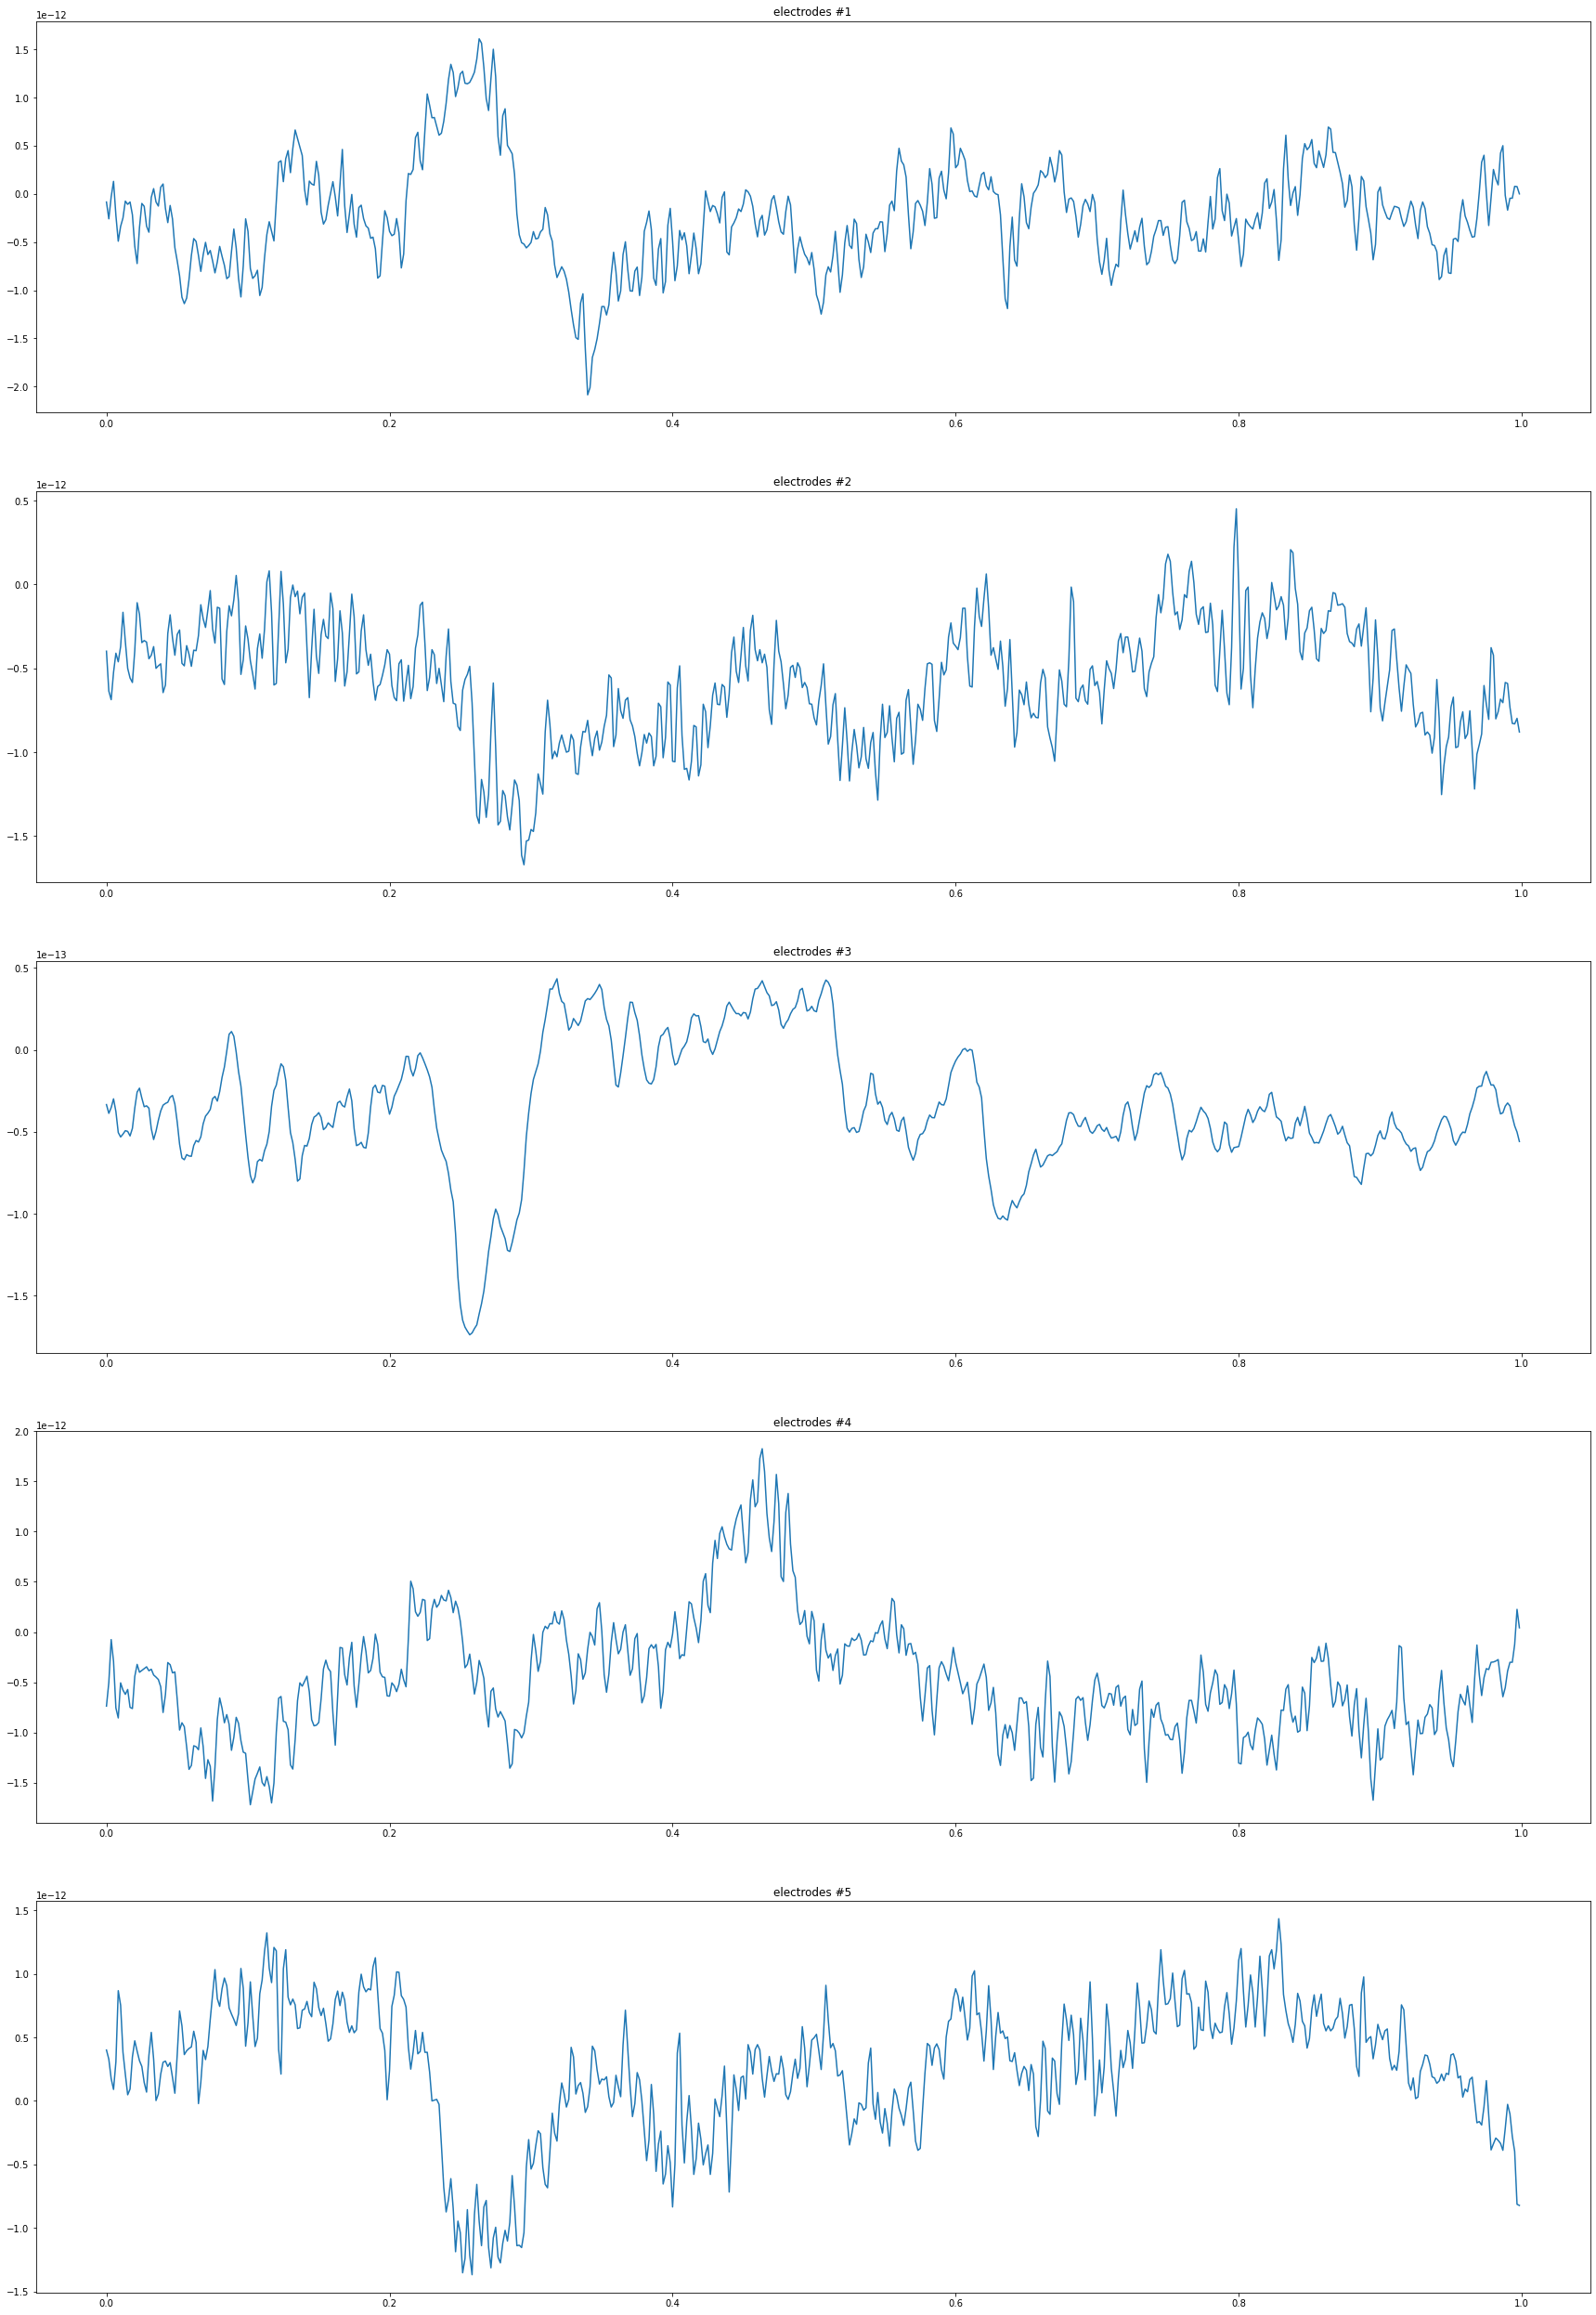

In [18]:
plt.figure(figsize=(30, 45))

for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(avg_time, avg_epoch[i, :])
    plt.title('electrodes #%d' % (i+1))

plt.show()

#### 3(c) Filtering and extracting epochs .

In [19]:
data_l2 = np.zeros((len(evt), meg_lowp.shape[0], (base_w+post_w)))
for ev in np.arange(len(evt)):
    data_l2[ev,:] = meg_lowp[:, evt[ev]-base_w : evt[ev]+post_w]
avg_epoch2 = np.mean(data_l2, axis = 0)

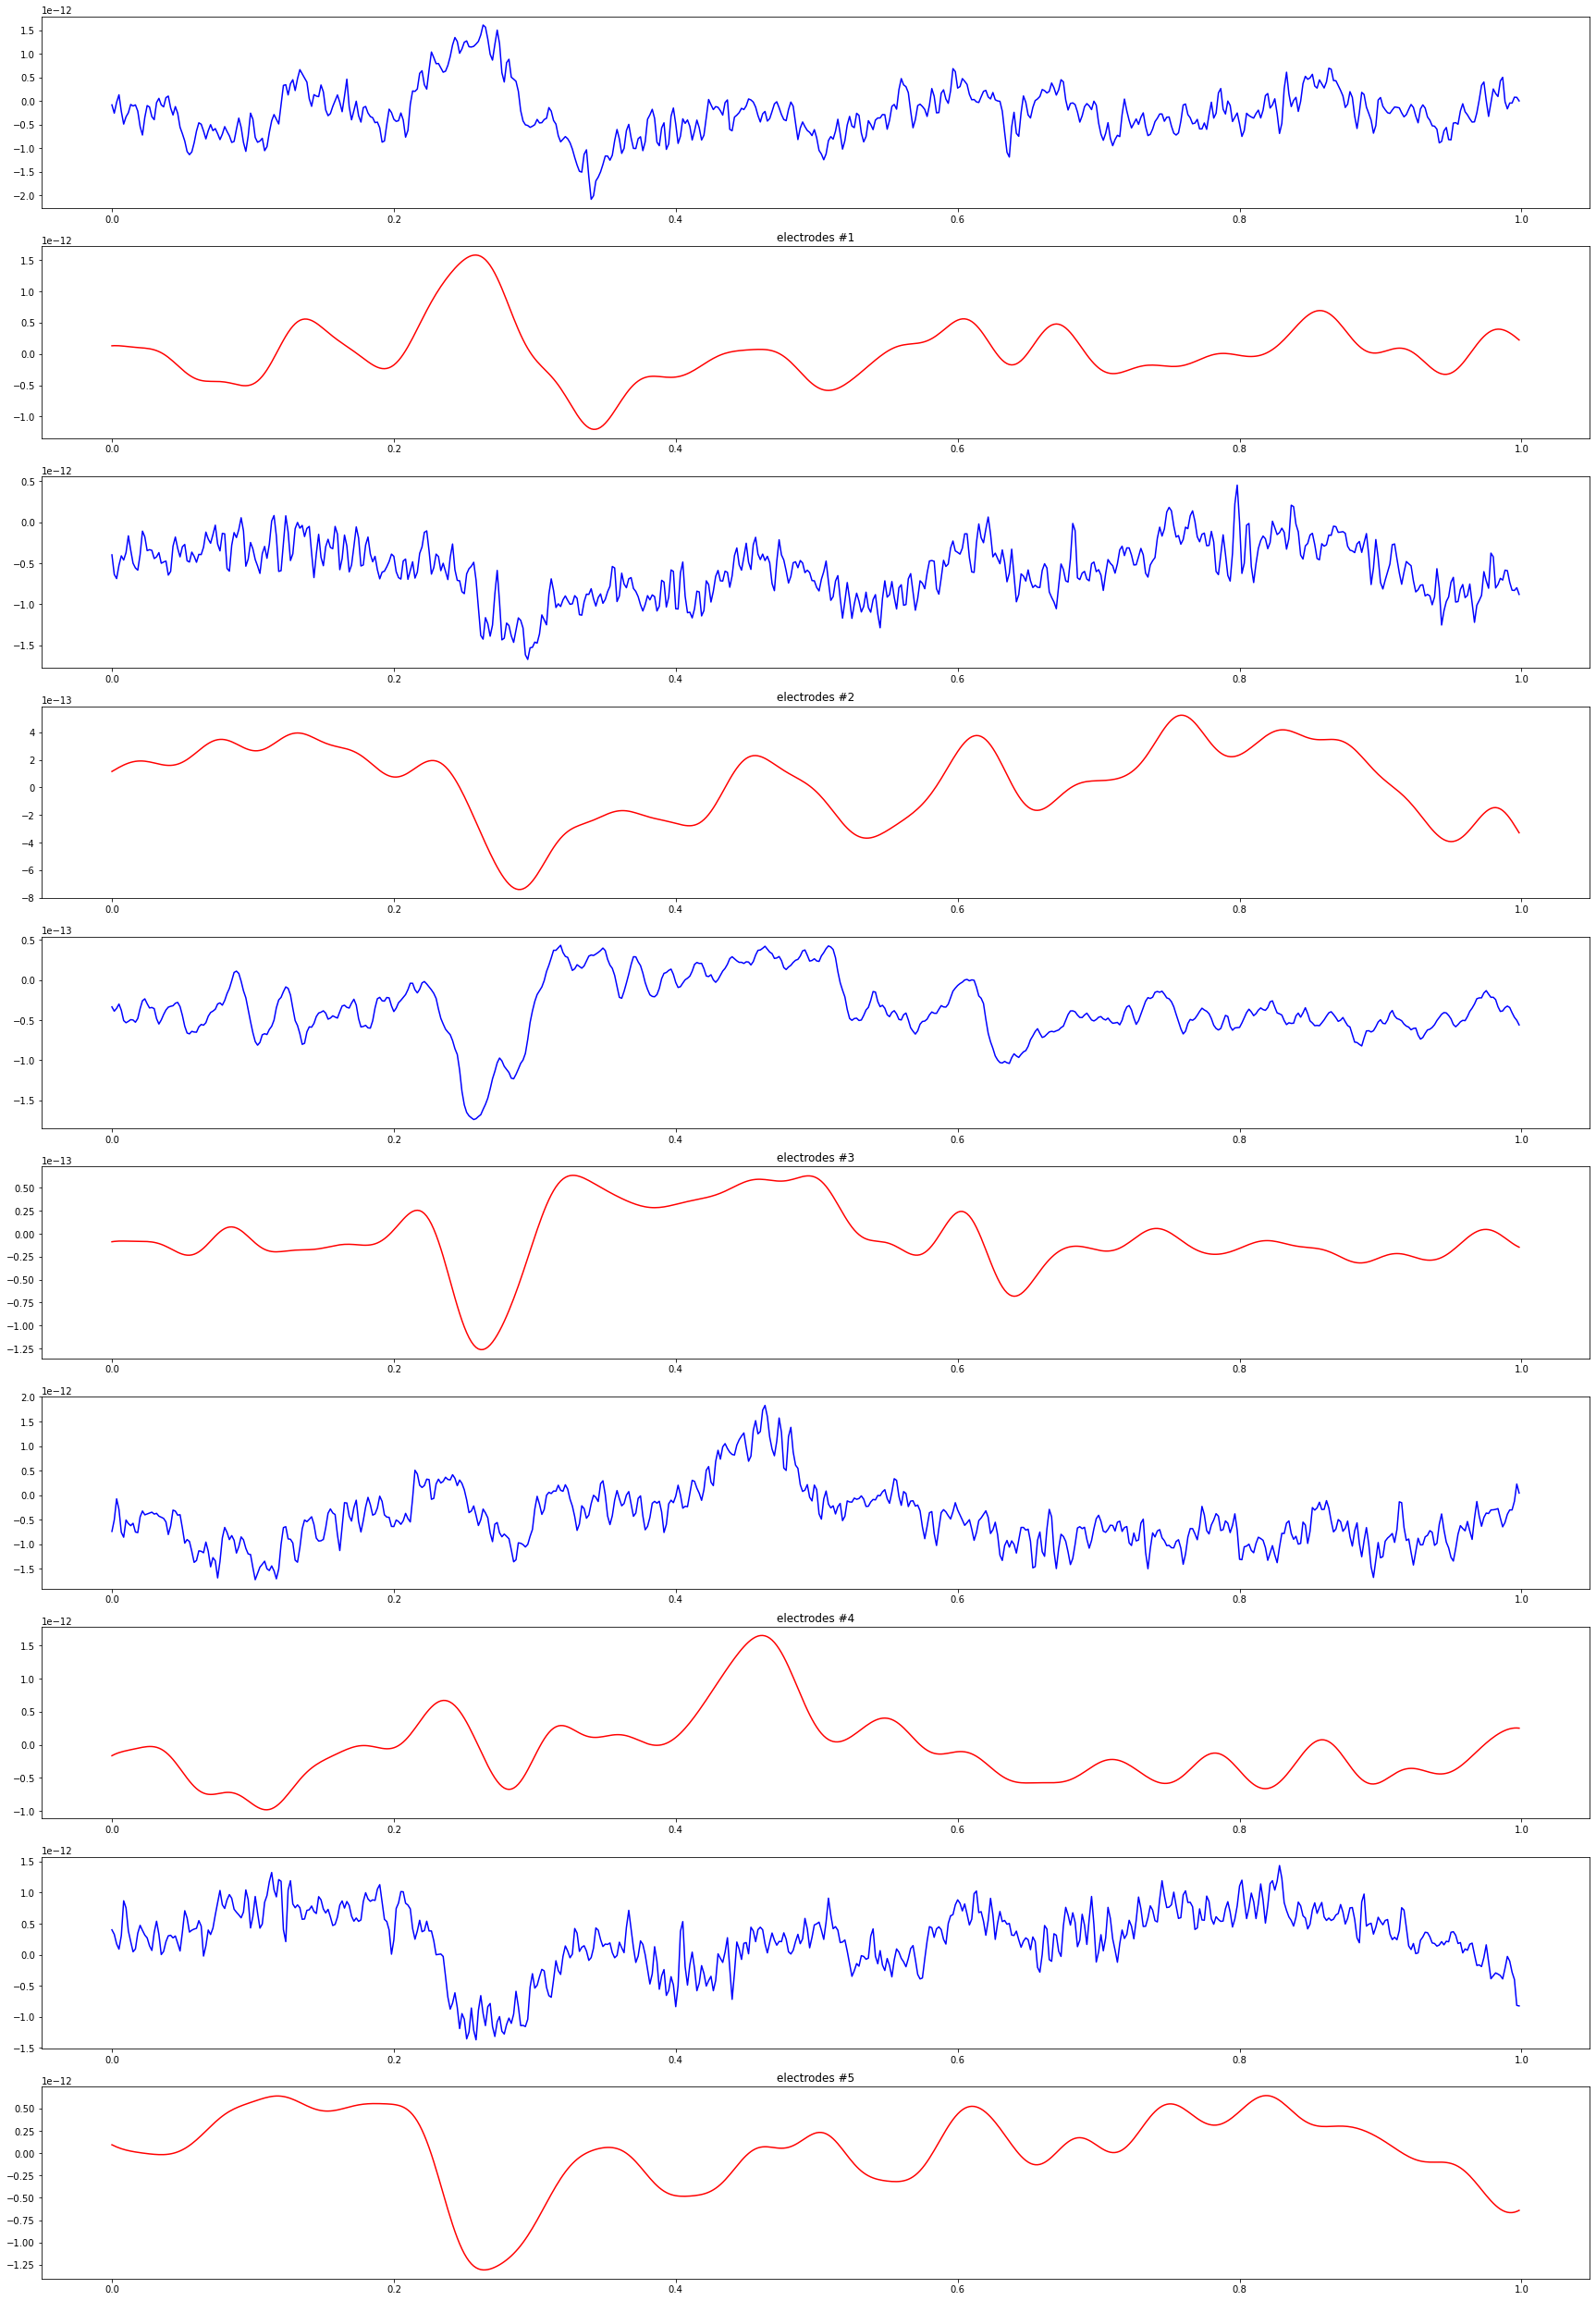

In [20]:
plt.figure(figsize=(30, 45))

for i in range(5):
    plt.subplot(10, 1, 2*i+1)
    plt.plot(avg_time, avg_epoch[i, :], c='b')
    plt.subplot(10, 1, 2*i+2)
    plt.plot(avg_time, avg_epoch2[i, :], c='r')
    plt.title('electrodes #%d' % (i+1))

plt.show()

#### 3(d) Describing effects of filtering on epochs

Average data after filtering have less fluctuations and more flat. There're more similar to each other since the local peaks located at same locations(ranges). But still these figures are not good enough to conclude a general tendency.. 

#### 3(e) Exploring effects of filtering

In [21]:
meg_lowp_only_o1 = filterSignal(20, fs, meg_data[:], lp=True, order=1)
meg_lowp_only_o7 = filterSignal(20, fs, meg_data[:], lp=True, order=7)
meg_lowp_only_o16 = filterSignal(20, fs, meg_data[:], lp=True, order=16)

In [22]:
print(filterSignal(20, fs, meg_data[:], lp=True, order=19)[1:100])

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


**order greater than 16 will cause nan, I don't know why...**

In [23]:
# order 1 avg epoch data
data_l_o1 = np.zeros((len(evt), meg_lowp_only_o1.shape[0], (base_w+post_w)))
for ev in np.arange(len(evt)):
    data_l_o1[ev,:] = meg_lowp_only_o1[:, evt[ev]-base_w : evt[ev]+post_w]
avg_epoch_o1 = np.mean(data_l_o1, axis = 0)

# order 7 avg epoch data
data_l_o7 = np.zeros((len(evt), meg_lowp_only_o7.shape[0], (base_w+post_w)))
for ev in np.arange(len(evt)):
    data_l_o7[ev,:] = meg_lowp_only_o7[:, evt[ev]-base_w : evt[ev]+post_w]
avg_epoch_o7 = np.mean(data_l_o7, axis = 0)

# order 16 avg epoch data
data_l_o16 = np.zeros((len(evt), meg_lowp_only_o16.shape[0], (base_w+post_w)))
for ev in np.arange(len(evt)):
    data_l_o16[ev,:] = meg_lowp_only_o16[:, evt[ev]-base_w : evt[ev]+post_w]
avg_epoch_o16 = np.mean(data_l_o16, axis = 0)

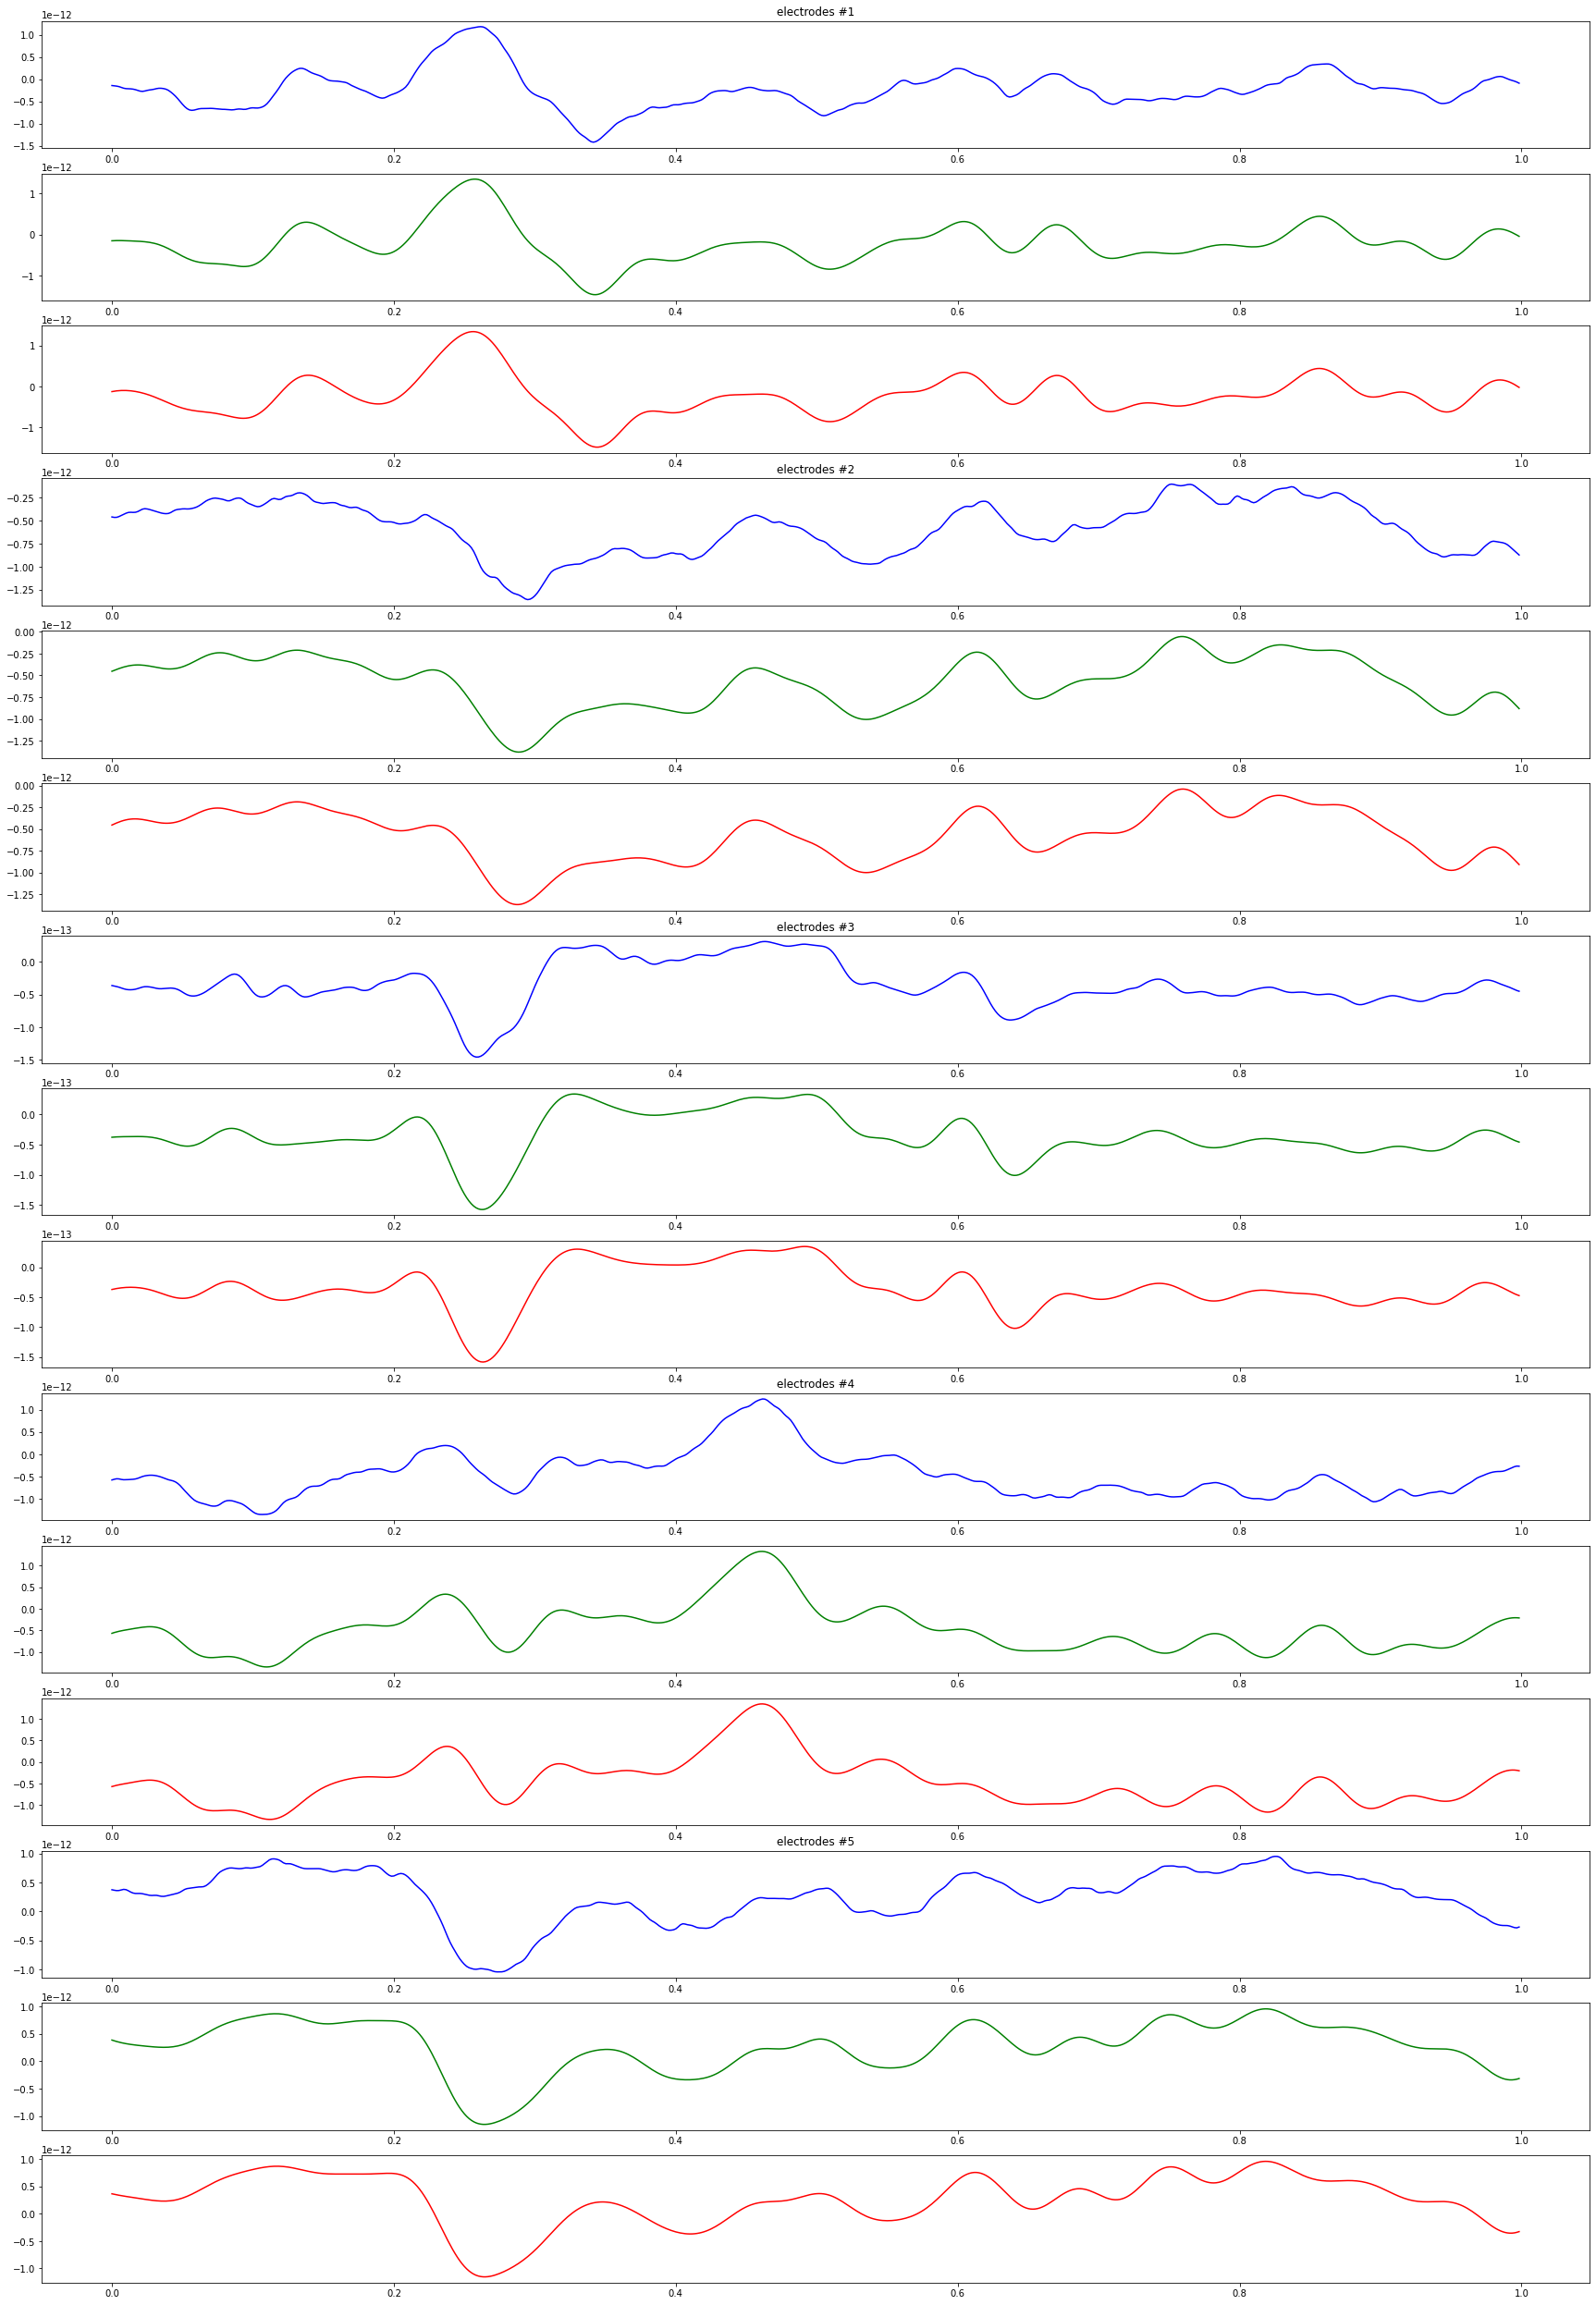

In [24]:
plt.figure(figsize=(30, 45))

for i in range(5):
    plt.subplot(15, 1, 3*i+1)
    plt.plot(avg_time, avg_epoch_o1[i, :], c='b')
    plt.title('electrodes #%d' % (i+1))
    plt.subplot(15, 1, 3*i+2)
    plt.plot(avg_time, avg_epoch_o7[i, :], c='g')
    plt.subplot(15, 1, 3*i+3)
    plt.plot(avg_time, avg_epoch_o16[i, :], c='r')

plt.show()

Larger orders produce signal graphs with less oscillation. For order 7 and order 16 I cannot see difference so I think order = 7 is enough.